### Simulation of cyan fluorescence in GFP populations using Discrete Time Markov Chains

In [24]:
rm(list = ls())

In [25]:
### Load all the releveant libraries
library("pracma")
library("flowCore")
library("caTools")
library("mixtools")
library("fitdistrplus")
library("SIBERG")
library("scatterplot3d") 

In [30]:
### Set the physical constants for simulations

T=37;        # Temp in centigrade
R=1.98e-3;   # Gas constant in Kcal/K/mol
beta=1/(R*(273+T));   # Boltzmann constant

### The range of accessible Free energy of folding
DG=seq(-20, 0, 0.1)

## Simulating the evolution GFP to Cyan 

##### Fluorescence

In [43]:
## Distribution of flourescence intensity of a library of GFP mutants
Facs=read.FCS("~/Dropbox/Wagner_Lab/Projects/Landscape_modeling/Paper_1_Robustness_Foldability/wt_yfp_distribution/5bs24_D8_D08_036.fcs")
WT=read.FCS("~/Dropbox/Wagner_Lab/Projects/Landscape_modeling/Paper_1_Robustness_Foldability/wt_yfp_distribution/wt1_D9_D09_037.fcs")

In [44]:
### Here we build a transition prabability matrix (P) for transitions between fluorescence intensities (X)

### The range of accessible fluorescence intensity (in log units)
X=seq(0, 10, 0.1)

P=matrix(0, nrow = length(X), ncol = length(X))

for (j in 1:length(X)){  ## Fill by row
       
data <- Facs@exprs[,8] ## Green intensity
fit <- fitLN(data, base=10, eps=10, d=NULL, model='V', zeroPercentThr=0.2, logLikToLN=TRUE)

## Fitting constants taken by modeling the brightness distribution
mu1 <- fit[1]
mu2 <- fit[2]
sigma1 <- fit[3]
sigma2 <-fit[4]
P1=0.23

    Xj=X[j]
    P_drift=P1*(1/sqrt(2*sigma1*sigma1*pi))*exp(-((X-mu1)^2)/(2*sigma1*sigma1))+(1-P1)*(1/sqrt(2*sigma2*sigma2*pi))*exp(-((X-Xj)^2)/(2*sigma2*sigma2));
    P_drift=P_drift/trapz(X,P_drift)
     
    P[j,] =P_drift

}

##### Stability

In [45]:
DG=seq(-20,0, 0.2)
States=seq(1, length(DG))

In [46]:
### Here we build a transition prabability matrix (Q) for transitions between protein stabilities

T=37;        #Temp in centigrade
R=1.98e-3;   #Gas constant in Kcal/K/mol
beta=1/(R*(273+T));   #Boltzman constant
N=1e3;

### Defining the transition probability matrix
Q=matrix(0, nrow = length(DG), ncol = length(DG))

for (i in 1:length(Q[,1])){  ## Fill by row
    
    DG_WT=DG[i]
    DG_mut=DG
    DDG=DG-DG_WT
    
    ### DDG distribution
    
    mu1=0.54;
    sigma1=0.98;
    mu2=2.05;
    sigma2=1.91;
    P1=0.49;
    PDDG=P1*(1/sqrt(2*sigma1*sigma1*pi))*exp(-((DDG-mu1)^2)/(2*sigma1*sigma1))+(1-P1)*(1/sqrt(2*sigma2*sigma2*pi))*exp(-((DDG-mu2)^2)/(2*sigma2*sigma2));

    P_int=PDDG
    P_int=P_int/trapz(DDG, P_int)
    
    Q[i,]=P_int
    
}

In [47]:
# simulate discrete Markov chains according to transition matrix (P or Q)
run.mc.sim <- function(P, num.iters, init_state) {
  
  # number of possible states
  num.states <- nrow(P)
  
  # stores the states X_t through time
  states     <- numeric(num.iters)

  # initialize variable for first state 
  states[1]    <- init_state

  for(t in 2:num.iters) {
    
    # probability vector to simulate next state X_{t+1}
    p  <- P[states[t-1], ]
    
    ## draw from multinomial and determine state
    states[t] <-  which(rmultinom(1, 1, p) == 1)
  }
  return(states)
}

In [48]:
Stability=list()


## We set a limit for abundance levels in simulations
limit=10
colfunc<-colorRampPalette(c("blue","red"))
cols=colfunc(limit)

## We advance each chain one step which represents the MUTATION cycle
num.iterations <- 2


for (thr in 1:limit){
States=seq(1, length(DG))

## Mean and Standard deviation of abundance modeled with a log-normal distribution
mean_q= thr*2 
sd_q=0.4*mean_q

## Number of Markov chains (each represents an individual within a population)
num.chains     <- 10000

## Matrices to record the NEXT state of Markov Chains for fluorescence input (X) and stability (DG)
chain.states_P <- matrix(NA, ncol=num.chains, nrow=num.iterations)
chain.states_Q <- matrix(NA, ncol=num.chains, nrow=num.iterations)

## Empty vectors to record the average and standard deviation of protein fluorescence and stability
X_mean=X_sd=K_mean=K_sd=DG_mean=DG_sd=rep(0, num.iterations)
Q_mean=P_mean=rep(0, 50)

## Number of evolved generations for each abundance level
num.generations=6

## Initial states of fluorescence and stability taken from experimental data (see Manuscript for details)
init_p=60
init_q=30

    
FL_list=P_list=Q_list=list()

for (super in 1:num.generations){

## Matrices to record the states of Markov Chains for fluorescence input (X) and stability (DG)
P_states <- matrix(NA, ncol=num.chains, nrow=50)
Q_states <- matrix(NA, ncol=num.chains, nrow=50)
P_list=list()
Q_list=list()
    
for(c in seq_len(num.chains)){
  chain.states_P[,c] <- run.mc.sim(P, num.iters = num.iterations, init_state = init_p)
  chain.states_Q[,c] <- run.mc.sim(Q, num.iters = num.iterations, init_state = init_q)     
}
  

### Stability of GFPs within a population
DG_pop=DG[chain.states_Q[num.iterations,]]

### Stability factor (-16 kcal/mol represents GFP' WT stability)
stab_factor_pop=1/(1+exp(DG_pop -(-16)))

### Abundance variation within the population (Gene Expression Noise)

Additive_A=rlnorm(length(DG_pop), meanlog = mean_q, sdlog = sd_q)

Additive_A[which(Additive_A<0)]=NA
            
FL_linear=Additive_A*stab_factor_pop*X[chain.states_P[num.iterations,]] 
    

##Selecting the top fluorescent molecules
index_keep=which((FL_linear > quantile(FL_linear, probs =0.9, na.rm = TRUE)))  


       
## Plot the situation at generation 20
if (super==20){

par(mfrow = c(1,3), pty="s")
label=paste("A=", as.character(mean_q))
plot(Additive_A, DG_pop, col="gray", main=label)
lines(Additive_A[index_keep],DG_pop[index_keep],  col="red", type="p", pch=19)

plot(Additive_A, FL_linear, type="p",col="gray")
lines(Additive_A[index_keep], FL_linear[index_keep],  type="p", pch=19, col="red")

plot(DG_pop, FL_linear, type="p", col="gray")
lines(DG_pop[index_keep], FL_linear[index_keep],  type="p", pch=19, col="red")
 
    
}
    

if (length(index_keep) > 0) {
    
if (length(index_keep)>0){
   FL_list[[super]]=FL_linear[index_keep] 
   
}    

    init_p=round(mean(chain.states_P[num.iterations ,index_keep], na.rm = TRUE))
    init_q=round(mean(chain.states_Q[num.iterations ,index_keep], na.rm = TRUE))
    
    P_states[super,index_keep]=chain.states_P[num.iterations ,index_keep]
    Q_states[super,index_keep]=chain.states_Q[num.iterations ,index_keep]
    
    P_list[[super]]=chain.states_P[num.iterations ,index_keep]
    Q_list[[super]]=chain.states_Q[num.iterations ,index_keep]
         
    X_mean[super]=mean(FL_list[[super]], na.rm = TRUE)
    X_sd[super]=sd(FL_list[[super]], na.rm = TRUE)
    
    K_mean[super]=mean(X[P_list[[super]]], na.rm = TRUE)
    K_sd[super]=sd(X[P_list[[super]]], na.rm = TRUE)
    
    DG_mean[super]=mean(DG[Q_list[[super]]], na.rm = TRUE)
    DG_sd[super]=sd(DG[Q_list[[super]]], na.rm = TRUE)
    
    
} else {
    
    message ("Selection purged the initial state")
}
        
}
    
Stability[[thr]]=DG[Q_list[[super]]]

}

In [49]:
i=1
dose=1+1*i
DOSE=rep(dose, length(Stability[[i]]))
MAT=cbind(DOSE, Stability[[i]])
         
for (i in 2:10){
    
dose=2*i ## Abundance in the plot

DOSE=rep(dose, length(Stability[[i]]))

MAT=rbind(MAT, cbind(DOSE, Stability[[i]]))
    
}

colnames(MAT)=c("Abundance","Stability")
MAT=as.data.frame(MAT)

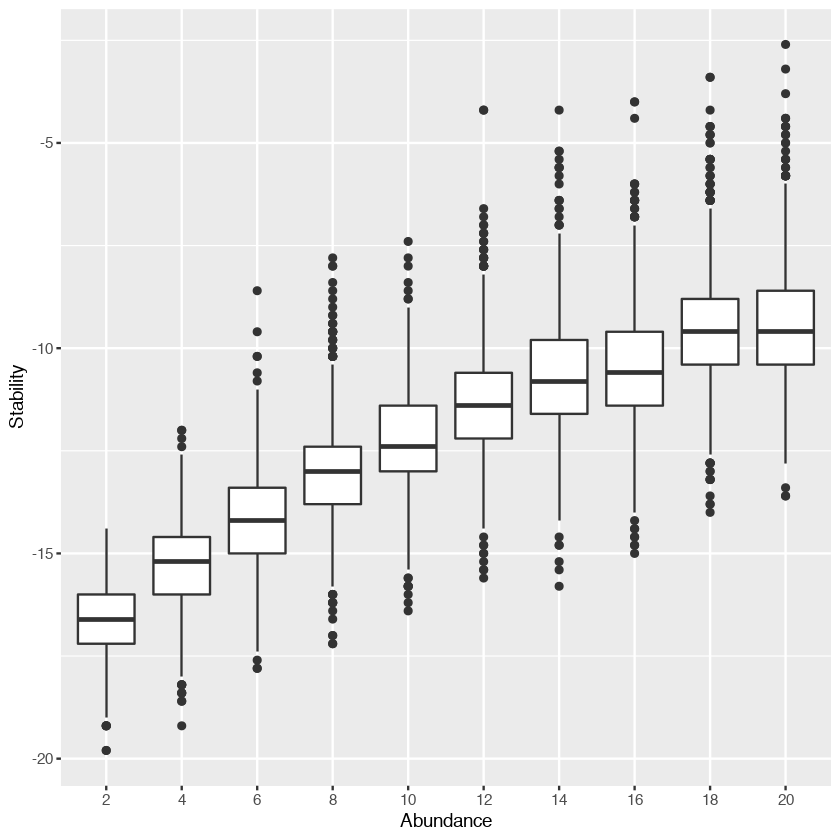

In [50]:
library(ggplot2)

MAT$Abundance <- as.factor(MAT$Abundance)

p <- ggplot(MAT, aes(x=Abundance, y=Stability)) + 
  geom_boxplot()
p
